### 1. Download and setup all necessary libraries.

In [2]:
!pip install tntorch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 61 kB 4.2 MB/s 


In [3]:
!pip install maxvolpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for maxvolpy: filename=maxvolpy-0.3.8-cp38-cp38-linux_x86_64.whl size=398520 sha256=b5e6f888bcaf491547c2268cd4688c36c5040ea2f0aa0da2a85f1d749ed42e0c
  Stored in directory: /root/.cache/pip/wheels/f6/83/7a/62ce6db59e5e28cf6477b1dff6b39681328d4dd47a36a0fd9a
Successfully built maxvolpy


In [4]:
import sys
sys.path.insert(0, 'wfa-extraction')
import time
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

### 2. Experiment function

In [5]:
import time

class Timer:
    def __init__(self):
        self.start = time.time()
        self.end = None

    def stop(self):
        self.end = time.time()

    def time(self):
        if self.end is None:
            self.stop()
        return self.end - self.start

In [6]:
from languages import Func

def get_function(F, alphabet_size):
    if not hasattr(F, '__call__'):
        F.alphabet_size = alphabet_size
        return F
    return Func(F, alphabet_size)

In [9]:
from tensor_extraction import extract_tensor_with_cross
from extraction import wfa_extraction
from spectral_learning import spectral_learning
from sets_creation import create_hankel_matrices, create_hankel_matrices_on_random_sets
from utils import func_difference_metrics


def experiment(func, filename, alphabet_size_list, ranks_list, n_list, max_length, max_iter):
    df_result = pd.DataFrame(columns=['alphabet_size',
                                      'rank',
                                      'n',
                                      'n_evaluations',
                                      'set_size',
                                      'tensor_extraction_time',
                                      'val_epss',
                                      'cross_wfa_extraction_time',
                                      'hankel_creation_time[short]',
                                      'spectral_wfa_extraction_time[short]',
                                      'hankel_creation_time[random]',
                                      'spectral_wfa_extraction_time[random]',
                                      'error_max[cross]',
                                      'error_avg[cross]',
                                      'error_max[short]',
                                      'error_avg[short]',
                                      'error_max[random]',
                                      'error_avg[random]'])
    
    for alphabet_size in alphabet_size_list:
        print('Starting experiment with alphabet_size={}'.format(alphabet_size))

        F = get_function(func, alphabet_size)

        for rank in ranks_list:
            print('Starting experiment with alphabet_size={}, rank={}'.format(alphabet_size, rank))
            for n in n_list:
                print('Starting experiment with alphabet_size={}, rank={}, n={}'.format(alphabet_size, rank, n))

                #tensor extraction
                tensor_extraction_time = Timer()
                tensor, info = extract_tensor_with_cross(F, n, rank=rank, max_iter=max_iter, verbose=True, return_info=True, kickrank=rank, rmax=1000)
                tensor_extraction_time.stop()
                print('Tensor was extracted, time={:.5}'.format(tensor_extraction_time.time()))
                n_evaluations = info['nsamples']
                print('The number of evaluations was {}'.format(n_evaluations))
                #automaton extraction from tensor
                cross_wfa_extraction_time = Timer()
                W_cross = wfa_extraction(tensor, rank=rank)
                cross_wfa_extraction_time.stop()
                print('WFA was extracted from tensor, time={:.5}'.format(cross_wfa_extraction_time.time()))

                #spectral learning [short]
                set_size = int(np.sqrt((n_evaluations + alphabet_size) // (alphabet_size + 1))) + 1
                print('The size of prefixes and suffixes set is {}'.format(set_size))
                set_size = max(set_size, rank + 1)
                #Hankel matrices creation
                hankel_creation_time = Timer()
                hPref, hSuf, H = create_hankel_matrices(F, kPref=set_size, kSuf=set_size)
                hankel_creation_time.stop()
                print('Hankel matrices has been created, time={:.5}'.format(hankel_creation_time.time()))
                #automaton extraction from Hankel matrices
                spectral_wfa_extraction_time = Timer()
                W_spectral = spectral_learning(hPref, hSuf, H, rank)
                spectral_wfa_extraction_time.stop()
                print('WFA was extracted from Hankel matrices, time={:.5}'.format(spectral_wfa_extraction_time.time()))

                #spectral learning [random]
                #Hankel matrices creation
                random_hankel_creation_time = Timer()
                hPref, hSuf, H = create_hankel_matrices_on_random_sets(F, n, n, set_size, set_size)
                random_hankel_creation_time.stop()
                print('Hankel matrices has been created, time={:.5}'.format(random_hankel_creation_time.time()))
                #automaton extraction from Hankel matrices
                random_spectral_wfa_extraction_time = Timer()
                W_random = spectral_learning(hPref, hSuf, H, rank)
                random_spectral_wfa_extraction_time.stop()
                print('WFA was extracted from Hankel matrices, time={:.5}'.format(random_spectral_wfa_extraction_time.time()))

                # difference evaluation
                cross_error_max, cross_error_avg = func_difference_metrics(F, W_cross, max_length=max_length)
                print('errors has been evaluated\ncross_error_max={}\ncross_error_avg={}'.format(cross_error_max, cross_error_avg))
                spectral_error_max, spectral_error_avg = func_difference_metrics(F, W_spectral, max_length=max_length)
                print('errors has been evaluated\nspectral_error_max={}\nspectral_error_avg={}'.format(spectral_error_max, spectral_error_avg))
                random_spectral_error_max, random_spectral_error_avg = func_difference_metrics(F, W_spectral, max_length=max_length)
                print('errors has been evaluated\nrandom_spectral_error_max={}\nrandom_spectral_error_avg={}'.format(random_spectral_error_max, random_spectral_error_avg))

                df_result = df_result.append({'alphabet_size': alphabet_size,
                                              'rank': rank,
                                              'n': n,
                                              'n_evaluations': n_evaluations,
                                              'set_size': set_size,
                                              'tensor_extraction_time': tensor_extraction_time.time(),
                                              'val_epss': info['val_epss'],
                                              'cross_wfa_extraction_time': cross_wfa_extraction_time.time(),
                                              'hankel_creation_time[short]': hankel_creation_time.time(),
                                              'spectral_wfa_extraction_time[short]': spectral_wfa_extraction_time.time(),
                                              'hankel_creation_time[random]': random_hankel_creation_time.time(),
                                              'spectral_wfa_extraction_time[random]': random_spectral_wfa_extraction_time.time(),
                                              'error_max[cross]': cross_error_max,
                                              'error_avg[cross]': cross_error_avg,
                                              'error_max[short]': spectral_error_max,
                                              'error_avg[short]': spectral_error_avg,
                                              'error_max[random]': random_spectral_error_max,
                                              'error_avg[random]': random_spectral_error_avg}, ignore_index=True)
        
        df_result.to_csv('csv_{}_{}.csv'.format(filename, alphabet_size))
        
    return df_result.astype({'alphabet_size': 'int64',
                             'rank': 'int64',
                             'n': 'int64',
                             'n_evaluations': 'int64',
                             'set_size': 'int64',
                             'tensor_extraction_time': 'float64',
                             'cross_wfa_extraction_time': 'float64',
                             'hankel_creation_time[short]': 'float64',
                             'spectral_wfa_extraction_time[short]': 'float64',
                             'hankel_creation_time[random]': 'float64',
                             'spectral_wfa_extraction_time[random]': 'float64'})

### 3. Experiment

In [10]:
from languages import get_aggregate_function
from wfa import RandomNormalWFA
from languages import Sum

W1 = RandomNormalWFA(20, 10, lval=0.5, rval=1.5, seed=239)
unary_operator = lambda x: (np.sin(x) ** 3) * 0.1
binary_operator = lambda x, y: x + y ** 2
W2 = Func(get_aggregate_function(unary_operator, binary_operator))
W = Sum(W1, W2)

df_result = experiment(W, filename='wfa-tensor', alphabet_size_list=[10, 15, 20], ranks_list=[10], n_list=[1, 2, 3, 4], max_length=10, max_iter=3)

Starting experiment with alphabet_size=10
Starting experiment with alphabet_size=10, rank=10
Starting experiment with alphabet_size=10, rank=10, n=1
cross device is None
Cross-approximation over a 3D domain containing 1331 grid points:
iter: 0 | eps: 9.851e-01 | time:   0.0288 | largest rank:   1
iter: 1 | eps: 4.171e-07 | time:   0.7715 | largest rank:  11 <- converged: eps < 1e-06
Did 3080 function evaluations, which took 0.7341s (4195 evals/s)

Tensor was extracted, time=1.1752
The number of evaluations was 3080
WFA was extracted from tensor, time=0.040823
The size of prefixes and suffixes set is 17
Hankel matrices has been created, time=0.066468
WFA was extracted from Hankel matrices, time=0.02317
Hankel matrices has been created, time=0.065584


/content/extraction.py:54: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3277.)
  alpha_inf = W.cores[2 * N].T[0][0]


WFA was extracted from Hankel matrices, time=0.004355
errors has been evaluated
cross_error_max=[0.00511964 0.02316086 0.20638686 0.46213782 0.88967978 1.10609847
 1.68725287 1.68260219 1.97885221 1.94091814 1.97216313]
cross_error_avg=[0.00511964 0.00732272 0.06393854 0.08318778 0.15624898 0.22119428
 0.28768048 0.34892073 0.38787557 0.44043069 0.49294791]
errors has been evaluated
spectral_error_max=[0.00839669 0.08937675 0.231154   0.58349564 0.8988075  1.22898331
 1.73949109 1.36655796 1.73526367 1.98429074 1.89348547]
spectral_error_avg=[0.00839669 0.03341149 0.09209088 0.11222361 0.14555582 0.1839294
 0.21453515 0.24980559 0.27128642 0.31222947 0.332606  ]
errors has been evaluated
random_spectral_error_max=[0.00839669 0.08937675 0.231154   0.58349564 0.96907281 1.1114792
 1.19482564 1.55707687 1.67469561 1.82741134 1.85921549]
random_spectral_error_avg=[0.00839669 0.03341149 0.09209088 0.11222361 0.14220843 0.17864014
 0.21058491 0.23739707 0.26781753 0.30279696 0.33537901]
Star

| eps: 1.574e-06 | time:  24.2448 | largest rank:  21 <- max_iter was reached: 3
Did 53449 function evaluations, which took 24.01s (2226 evals/s)

Tensor was extracted, time=24.659
The number of evaluations was 53449
WFA was extracted from tensor, time=0.0042117
The size of prefixes and suffixes set is 70
Hankel matrices has been created, time=1.0713
WFA was extracted from Hankel matrices, time=0.001354
Hankel matrices has been created, time=1.6346
WFA was extracted from Hankel matrices, time=0.0020497
errors has been evaluated
cross_error_max=[0.00937479 0.10874654 0.10187813 0.12618382 0.13034038 0.14172223
 0.14242463 0.15119645 0.14461433 0.14931385 0.15717966]
cross_error_avg=[0.00937479 0.04114694 0.0408396  0.04331039 0.04514085 0.04126476
 0.04277226 0.04506462 0.04210061 0.04233382 0.0408749 ]
errors has been evaluated
spectral_error_max=[0.00780364 0.10932463 0.1522115  0.21706245 0.2707371  0.39580425
 0.32343692 0.42349814 0.3559514  0.67281548 0.59534725]
spectral_error_av

| eps: 2.304e-06 | time:  40.0803 | largest rank:  21 <- max_iter was reached: 3
Did 78221 function evaluations, which took 39.75s (1968 evals/s)

Tensor was extracted, time=40.57
The number of evaluations was 78221
WFA was extracted from tensor, time=0.0056832
The size of prefixes and suffixes set is 85
Hankel matrices has been created, time=1.6769
WFA was extracted from Hankel matrices, time=0.001956
Hankel matrices has been created, time=2.7856
WFA was extracted from Hankel matrices, time=0.0014811
errors has been evaluated
cross_error_max=[0.001083   0.09838894 0.0993443  0.10583499 0.1063023  0.10663255
 0.10952959 0.10683715 0.10687519 0.10854218 0.12441074]
cross_error_avg=[0.001083   0.04097135 0.04197739 0.04254708 0.04349094 0.04123454
 0.04069176 0.041381   0.04013206 0.04142411 0.04071705]
errors has been evaluated
spectral_error_max=[0.01027317 0.12680181 0.13057222 0.28131524 0.32953121 0.47570286
 0.41480505 0.46811654 0.58866798 0.76248438 0.81473247]
spectral_error_avg

| eps: 1.151e-06 | time:  15.2675 | largest rank:  21 <- max_iter was reached: 3
Did 48672 function evaluations, which took 15.14s (3215 evals/s)

Tensor was extracted, time=15.598
The number of evaluations was 48672
WFA was extracted from tensor, time=0.0039942
The size of prefixes and suffixes set is 56
Hankel matrices has been created, time=0.9264
WFA was extracted from Hankel matrices, time=0.0015223
Hankel matrices has been created, time=1.1732
WFA was extracted from Hankel matrices, time=0.0013075
errors has been evaluated
cross_error_max=[0.02105503 0.11975343 0.12762062 0.16828403 0.21751427 0.25912253
 0.30484851 0.24894933 0.35606646 0.4461716  0.35250826]
cross_error_avg=[0.02105503 0.04732284 0.04379564 0.05034771 0.0499502  0.05353558
 0.0534129  0.05443432 0.05718219 0.0596611  0.06074535]
errors has been evaluated
spectral_error_max=[0.00974813 0.13166736 0.19610823 0.33323736 0.42515114 0.53343583
 0.54404298 0.74281316 0.7147955  0.78674247 0.73367237]
spectral_error_a

| eps: 1.626e-06 | time:  34.2946 | largest rank:  21 <- max_iter was reached: 3
Did 84704 function evaluations, which took 34.08s (2485 evals/s)

Tensor was extracted, time=34.696
The number of evaluations was 84704
WFA was extracted from tensor, time=0.0038452
The size of prefixes and suffixes set is 73
Hankel matrices has been created, time=1.7602
WFA was extracted from Hankel matrices, time=0.0014725
Hankel matrices has been created, time=2.5483
WFA was extracted from Hankel matrices, time=0.0027287
errors has been evaluated
cross_error_max=[0.00858153 0.1042209  0.10538679 0.11831296 0.12310739 0.12176301
 0.13076105 0.13542786 0.13928944 0.1471429  0.14424508]
cross_error_avg=[0.00858153 0.04753494 0.04212242 0.04228249 0.04359016 0.04304031
 0.04300858 0.04294066 0.04089033 0.0394163  0.03944279]
errors has been evaluated
spectral_error_max=[0.00581435 0.10345886 0.16246166 0.21051848 0.20814371 0.26456514
 0.44349538 0.37889493 0.36548978 0.57558705 0.55078521]
spectral_error_a

| eps: 2.383e-06 | time:  59.9263 | largest rank:  21 <- max_iter was reached: 3
Did 120736 function evaluations, which took 59.6s (2026 evals/s)

Tensor was extracted, time=60.44
The number of evaluations was 120736
WFA was extracted from tensor, time=0.010423
The size of prefixes and suffixes set is 87
Hankel matrices has been created, time=2.426
WFA was extracted from Hankel matrices, time=0.0016634
Hankel matrices has been created, time=4.2968
WFA was extracted from Hankel matrices, time=0.0054066
errors has been evaluated
cross_error_max=[0.00027501 0.09779677 0.10159039 0.10246423 0.10233607 0.10511717
 0.10716056 0.10465429 0.10516556 0.10544564 0.11022869]
cross_error_avg=[0.00027501 0.04687151 0.04218386 0.04120161 0.04033568 0.04034124
 0.04027215 0.03881221 0.03883579 0.03922573 0.0382147 ]
errors has been evaluated
spectral_error_max=[0.04364247 0.13715637 0.16930658 0.19199287 0.20225257 0.24826491
 0.34898526 0.42582629 0.47782167 0.50394164 0.59139989]
spectral_error_avg

| eps: 1.091e-06 | time:  23.0078 | largest rank:  21 <- max_iter was reached: 3
Did 73017 function evaluations, which took 22.89s (3189 evals/s)

Tensor was extracted, time=23.354
The number of evaluations was 73017
WFA was extracted from tensor, time=0.0034854
The size of prefixes and suffixes set is 59
Hankel matrices has been created, time=1.3192
WFA was extracted from Hankel matrices, time=0.0024681
Hankel matrices has been created, time=1.6692
WFA was extracted from Hankel matrices, time=0.0025187
errors has been evaluated
cross_error_max=[0.02665571 0.12637732 0.13196989 0.16300431 0.17732106 0.17368999
 0.18566476 0.23217064 0.32429979 0.24620754 0.43150583]
cross_error_avg=[0.02665571 0.04177106 0.04429912 0.04857461 0.04983565 0.04960945
 0.05117954 0.05185942 0.05381471 0.05540751 0.05485028]
errors has been evaluated
spectral_error_max=[0.00396103 0.08512157 0.20923869 0.30266847 0.34476136 0.50214305
 0.49537655 0.81484201 0.78269753 0.93563596 1.19116312]
spectral_error_a

| eps: 1.780e-06 | time:  48.8463 | largest rank:  21 <- max_iter was reached: 3
Did 120309 function evaluations, which took 48.63s (2474 evals/s)

Tensor was extracted, time=49.263
The number of evaluations was 120309
WFA was extracted from tensor, time=0.0043824
The size of prefixes and suffixes set is 76
Hankel matrices has been created, time=2.3612
WFA was extracted from Hankel matrices, time=0.0026109
Hankel matrices has been created, time=3.6323
WFA was extracted from Hankel matrices, time=0.0017295
errors has been evaluated
cross_error_max=[0.00362013 0.10253601 0.10244734 0.11147995 0.10892139 0.11692314
 0.11505027 0.12400913 0.12207907 0.1329302  0.16253746]
cross_error_avg=[0.00362013 0.04455045 0.04183933 0.04145911 0.0412454  0.0418883
 0.04240774 0.03930881 0.0400733  0.03988988 0.04020473]
errors has been evaluated
spectral_error_max=[0.014369   0.11359359 0.19850619 0.23243715 0.35860477 0.36597856
 0.42876784 0.46317851 0.61189932 0.57599842 0.70423724]
spectral_error_

| eps: 2.758e-06 | time:  81.8561 | largest rank:  21 <- max_iter was reached: 3
Did 167601 function evaluations, which took 81.52s (2056 evals/s)

Tensor was extracted, time=82.401
The number of evaluations was 167601
WFA was extracted from tensor, time=0.0071621
The size of prefixes and suffixes set is 90
Hankel matrices has been created, time=3.2687
WFA was extracted from Hankel matrices, time=0.0028551
Hankel matrices has been created, time=6.0359
WFA was extracted from Hankel matrices, time=0.0026751
errors has been evaluated
cross_error_max=[0.0002107  0.09987087 0.10082869 0.10101085 0.10217296 0.10102377
 0.10228148 0.10260002 0.10233685 0.10238135 0.10465792]
cross_error_avg=[0.0002107  0.04396366 0.0417786  0.04196889 0.04329858 0.04169072
 0.03878227 0.03929913 0.03978233 0.039369   0.03490372]
errors has been evaluated
spectral_error_max=[0.01386431 0.10899659 0.1953907  0.23221811 0.23570156 0.40844074
 0.31691503 0.38623656 0.79033287 0.53039901 0.58038664]
spectral_error

In [11]:
df_result.head()

,alphabet_size,rank,n,n_evaluations,set_size,tensor_extraction_time,val_epss,cross_wfa_extraction_time,hankel_creation_time[short],spectral_wfa_extraction_time[short],hankel_creation_time[random],spectral_wfa_extraction_time[random],error_max[cross],error_avg[cross],error_max[short],error_avg[short],error_max[random],error_avg[random]
0,10,10,1,3080,17,1.175164,"[tensor(0.9851), tensor(4.1709e-07)]",0.040823,0.066468,0.023170,0.065584,0.004355,"[0.005119643458945167, 0.023160861101916175, 0...","[0.005119643458945167, 0.007322724691454253, 0...","[0.00839668949387734, 0.08937674985746485, 0.2...","[0.00839668949387734, 0.03341148784116091, 0.0...","[0.00839668949387734, 0.08937674985746485, 0.2...","[0.00839668949387734, 0.03341148784116091, 0.0..."
1,10,10,2,28677,52,9.628436,"[tensor(1.0041), tensor(0.1400), tensor(8.1321...",0.002444,0.597692,0.002301,0.682989,0.002262,"[0.0335968672850932, 0.11084023861653161, 0.13...","[0.0335968672850932, 0.04477247005131214, 0.04...","[0.023293824331422353, 0.13567343466853982, 0....","[0.023293824331422353, 0.044183394560008006, 0...","[0.023293824331422353, 0.13567343466853982, 0....","[0.023293824331422353, 0.044183394560008006, 0..."
2,10,10,3,53449,70,24.659353,"[tensor(0.9987), tensor(0.1334), tensor(1.5739...",0.004212,1.071309,0.001354,1.634595,0.002050,"[0.00937478958273913, 0.10874654125547265, 0.1...","[0.00937478958273913, 0.04114693616853633, 0.0...","[0.007803637114608769, 0.1093246277447106, 0.1...","[0.007803637114608769, 0.04422269930507865, 0....","[0.007803637114608769, 0.1093246277447106, 0.1...","[0.007803637114608769, 0.04422269930507865, 0...."
3,10,10,4,78221,85,40.570251,"[tensor(0.9999), tensor(0.0804), tensor(2.3041...",0.005683,1.676933,0.001956,2.785573,0.001481,"[0.0010830048759752908, 0.09838893890875944, 0...","[0.0010830048759752908, 0.040971350354317385, ...","[0.010273171738748366, 0.12680181226342874, 0....","[0.010273171738748366, 0.04655447381862221, 0....","[0.010273171738748366, 0.12680181226342874, 0....","[0.010273171738748366, 0.04655447381862221, 0...."
4,15,10,1,13440,29,3.398326,"[tensor(1.0036), tensor(0.2337), tensor(4.3679...",0.003120,0.247715,0.002392,0.229953,0.002206,"[0.025762157977742672, 0.0787247259896818, 0.3...","[0.025762157977742672, 0.036538257226985865, 0...","[0.04060141823639152, 0.08590047201026066, 0.2...","[0.04060141823639152, 0.03611775319772411, 0.0...","[0.04060141823639152, 0.08590047201026066, 0.2...","[0.04060141823639152, 0.03611775319772411, 0.0..."


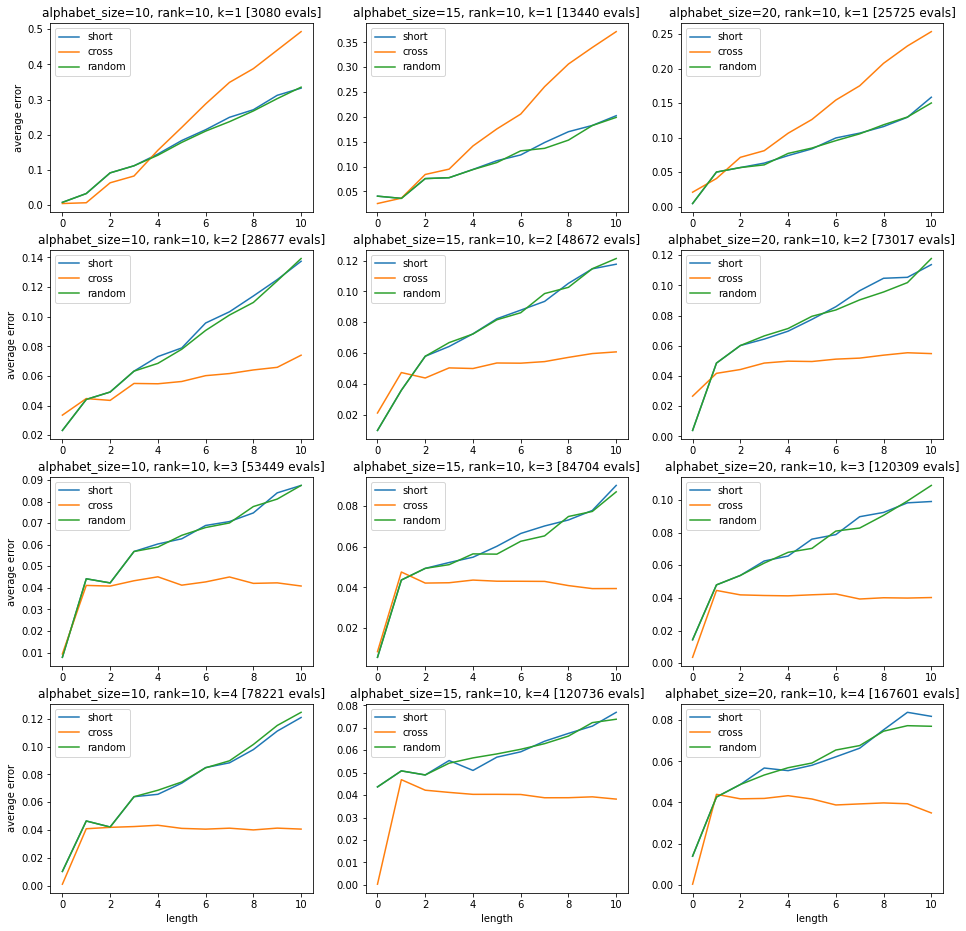

In [12]:
from matplotlib.backends.backend_pdf import PdfPages

pdf = PdfPages('plots_avg1.pdf')
crop_len = 10

f, arr = plt.subplots(4, 3)
f.set_figheight(16)
f.set_figwidth(16)

cnt = 0
for index, row in df_result.iterrows():
    idx = np.arange(crop_len + 1)
    alphabet_size = row['alphabet_size']
    rank = row['rank']
    n = row['n']
    x = n - 1
    y = (alphabet_size // 5) - 2
    arr[x][y].plot(idx, row['error_avg[short]'][:(crop_len + 1)], label='short')
    arr[x][y].plot(idx, row['error_avg[cross]'][:(crop_len + 1)], label='cross')
    arr[x][y].plot(idx, row['error_avg[random]'][:(crop_len + 1)], label='random')
    arr[x][y].legend()
    arr[x][y].title.set_text('alphabet_size={}, rank={}, k={} [{} evals]'.format(alphabet_size, rank, n, row['n_evaluations']))
    if y == 0:
        arr[x][y].set_ylabel('average error')
    if x == 3:
        arr[x][y].set_xlabel('length')
    cnt += 1

pdf.savefig(f)
pdf.close()

f.savefig('plots3.jpg', bbox_inches='tight', pad_inches=0.01)

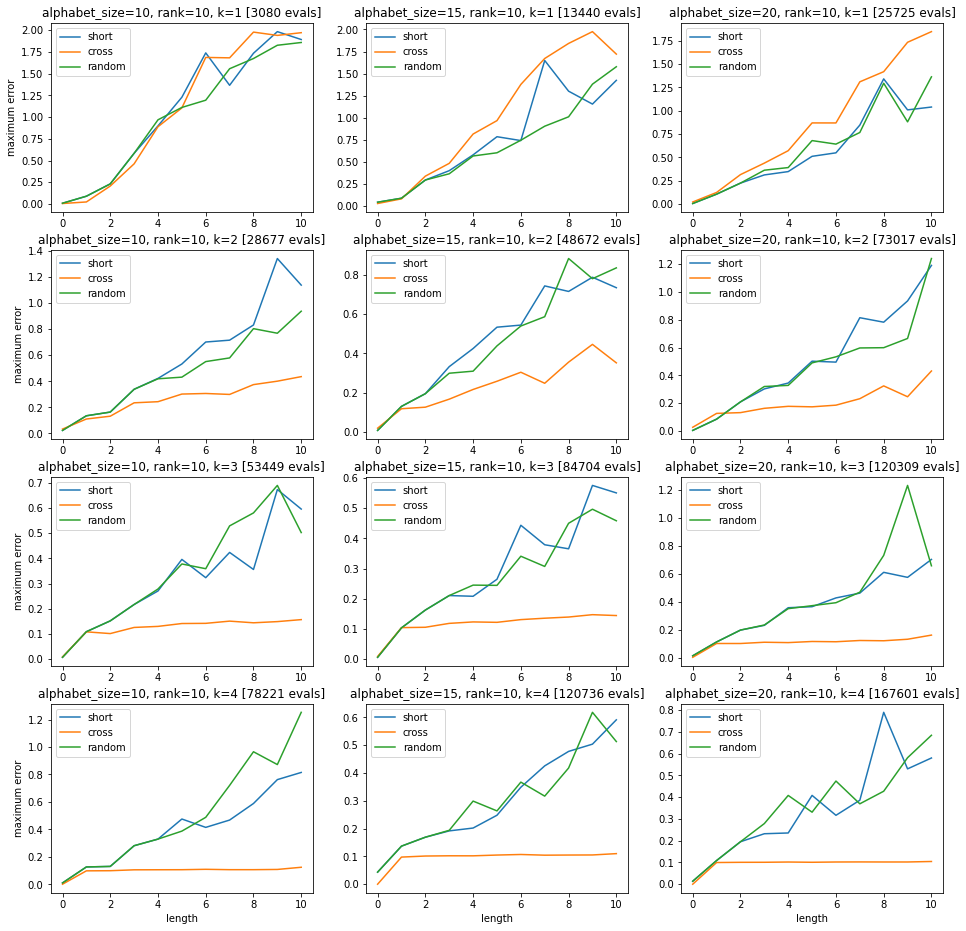

In [13]:
from matplotlib.backends.backend_pdf import PdfPages

pdf = PdfPages('plots_max1.pdf')
crop_len = 10

f, arr = plt.subplots(4, 3)
f.set_figheight(16)
f.set_figwidth(16)

cnt = 0
for index, row in df_result.iterrows():
    idx = np.arange(crop_len + 1)
    alphabet_size = row['alphabet_size']
    rank = row['rank']
    n = row['n']
    x = n - 1
    y = (alphabet_size // 5) - 2
    arr[x][y].plot(idx, row['error_max[short]'][:(crop_len + 1)], label='short')
    arr[x][y].plot(idx, row['error_max[cross]'][:(crop_len + 1)], label='cross')
    arr[x][y].plot(idx, row['error_max[random]'][:(crop_len + 1)], label='random')
    arr[x][y].legend()
    arr[x][y].title.set_text('alphabet_size={}, rank={}, k={} [{} evals]'.format(alphabet_size, rank, n, row['n_evaluations']))
    if y == 0:
        arr[x][y].set_ylabel('maximum error')
    if x == 3:
        arr[x][y].set_xlabel('length')
    cnt += 1

pdf.savefig(f)
pdf.close()

f.savefig('plots4.jpg', bbox_inches='tight', pad_inches=0.01)